In [12]:
import os
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score
# from sklearn.manifold import TSNE
import matplotlib  as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
%matplotlib inline
import os, shutil, glob
from random import randint
import seaborn as sns; sns.set_style("white")
import umap as umap

# import plotnine as gg
# from cytominer_eval import evaluate

print(os.getcwd())
os.chdir('/scratch2-shared/david/colopaint3D/notebooks/')
print(os.getcwd())


/scratch2-shared/david/colopaint3D/notebooks
/scratch2-shared/david/colopaint3D/notebooks


In [13]:
figformat = 'pdf'
dpi = 300
statarg = 'single'
OutputDir = f'./output/spher010/2_PCAUMAP'
if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)
FeatureDir = './output/spher010/1_FeaturesImages'


In [14]:
filenames = ['spheroidspher010-DLD1-L5', 'spheroidspher010-HCT15-L2', 'spheroidspher010-HT29-L4']
statmets = ['Median', 'Mean']

In [8]:
def readData(filename, statmet='SingleCell'):
    read_data = pd.read_parquet(f'{FeatureDir}/{filename}{statmet}.parquet')
    cbar = pd.DataFrame()
    read_data.reset_index(inplace=True, drop = True)
    training_data = read_data.copy()
    loc_data = training_data[['Nuclei_Location_Center_X','Nuclei_Location_Center_Y', 'Metadata_Well', 'Metadata_Site']]
    training_data = training_data.loc[:,~training_data.columns.str.contains('Location', case=True)]
    training_data = training_data.loc[:,~training_data.columns.str.contains('ImageNumber_', case=True)]
    training_data = training_data.loc[:,~training_data.columns.str.contains('Parent', case=True)]
    training_data = training_data.loc[:,~training_data.columns.str.contains('Children', case=True)]
    training_data = training_data.loc[:,~training_data.columns.str.contains('_ObjectNumber', case=True)]
    training_data = training_data.loc[:,~training_data.columns.str.contains('_Object_Number', case=True)]
    training_data = training_data.loc[:,~training_data.columns.str.contains('_Y', case=True)]
    training_data = training_data.loc[:,~training_data.columns.str.contains('_X', case=True)]
    training_data = training_data.copy()

    toNpy = training_data.loc[:,~training_data.columns.str.contains('Metadata_|onehot')]
    toNpy.reset_index(inplace=True, drop=True)
    toNpy = toNpy.copy()
    dataNpy = toNpy.to_numpy()
    colnames = toNpy.columns
    
    dataLabel = oneHot(training_data)
    dataLabel[['Metadata_Radius', 'Metadata_Theta']] = loc_data.apply(calculate_centered_polar_coordinates, axis=1)
    dataLabel[['Metadata_Well', 'Metadata_Site']] = loc_data[['Metadata_Well', 'Metadata_Site']]
    return dataNpy, dataLabel

def oneHot(training_data):
    ### New Onehot
    target = pd.DataFrame()
    onehot_val = list(range(len(training_data['Metadata_Cmpd'].unique())))
    onehot_dict = dict(zip(training_data['Metadata_Cmpd'].unique(), onehot_val))
    target['onehot'] = training_data['Metadata_Cmpd'].apply(lambda x: onehot_dict.get(x, -1))
    training_data['onehot'] = target['onehot']



    dataLabel = pd.DataFrame()
    dataLabel['Metadata_Cmpd'] = training_data['Metadata_Cmpd']
    dataLabel['onehot'] = training_data['onehot']

    # dataUMAP = pd.DataFrame()
    # dataUMAP['Metadata_Cmpd'] = training_data['Metadata_Cmpd']
    # dataUMAP['onehot'] = training_data['onehot']
    return dataLabel

def calculate_centered_polar_coordinates(row):
    x = row['Nuclei_Location_Center_X'] - 512
    y = row['Nuclei_Location_Center_Y'] - 512
    radius = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return pd.Series({'Nuclei_Location_Radius': radius, 'Nuclei_Location_Theta': theta})


def makePCA(dataN, dataPCA, hue_name='Metadata_Cmpd', name='', statmet='SingleCell' , n_components=2):
    pca_model = PCA(n_components=  2)
    pca_model = pca_model.fit(dataN)
    pcaOut = pca_model.transform(dataN)
    dataPCA['pc1'] = pcaOut[:,0]
    dataPCA['pc2'] = pcaOut[:,1]
    dataPCA = dataPCA.copy()

    # cmap = sns.color_palette("hls", n_colors=11)
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    hue = dataPCA[hue_name]
    # hue = training_data['cluster']

    fig = plt.figure(figsize=[14, 5])
    ax = fig.add_subplot(121)
    ax.set_xlabel('PC 1', fontsize = 10)
    ax.set_ylabel('PC 2', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    sns.scatterplot(x="pc1", y="pc2",
                        palette=cmap, hue=hue,
                        marker='.',
                        data=dataPCA).set(title=f'PCA {name} All'
                )


    noInert = dataPCA[~(dataPCA['Metadata_Cmpd'] == 'dmso')]
    noInert = noInert[~(noInert['Metadata_Cmpd'] == 'sorb')]
    ax.set_facecolor('w')
    ax.get_legend().remove()
    # ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax = fig.add_subplot(122)
    ax.set_xlabel('PC 1', fontsize = 10)
    ax.set_ylabel('PC 2', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    sns.scatterplot(x="pc1", y="pc2",
                        palette=cmap, hue=hue,
                        marker='.',
                        data=noInert).set(title=f'PCA {name} no Inert'
                )
    ax.set_facecolor('w')
    # ax.get_legend().remove()
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # if not os.path.exists(f'{OutputDir}/{statmet}/{hue_name}'): 
    #     os.makedirs(f'{OutputDir}/{statmet}/{hue_name}')
    # plt.savefig(f'{OutputDir}/{statmet}/{name}_pca.png')
    plt.show()
    plt.close()
    return dataPCA

def makeUMAP(dataN, dataUMAP, hue_name='Metadata_Cmpd', name='', statmet='SingleCell' , nn = 100, is_supervised=True, n_components=2, min_dist=0.2, spread= 5, n_epochs=None, metric='cosine',):
    umap_model = umap.UMAP(n_neighbors=nn
                        , min_dist=min_dist
                        , spread= spread
                        , n_epochs=n_epochs
                        , metric=metric
                        )
    if is_supervised:
        umapOut = umap_model.fit_transform(dataN, y=dataUMAP['onehot'])
        isSup = 'Supervised'
    else:
        umapOut = umap_model.fit_transform(dataN)
        isSup = 'Unsupervised'
    dataUMAP['umap1'] = umapOut[:,0]
    dataUMAP['umap2'] = umapOut[:,1]
    dataUMAP = dataUMAP.copy()

    # cmap = sns.color_palette("hls", n_colors=11)
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    hue = dataUMAP[hue_name]
    # hue = training_data['cluster']

    fig = plt.figure(figsize=[14, 5])
    ax = fig.add_subplot(121)
    ax.set_xlabel('UMAP 1', fontsize = 10)
    ax.set_ylabel('UMAP 2', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    sns.scatterplot(x="umap1", y="umap2",
                        palette=cmap, hue=hue,
                        marker='.',
                        data=dataUMAP).set(title=f'UMAP {isSup} {name} all'
                )


    noInert = dataUMAP[~(dataUMAP['Metadata_Cmpd'] == 'dmso')]
    noInert = noInert[~(noInert['Metadata_Cmpd'] == 'sorb')]
    ax.set_facecolor('w')
    ax.get_legend().remove()

    ax = fig.add_subplot(122)
    ax.set_xlabel('UMAP 1', fontsize = 10)
    ax.set_ylabel('UMAP 2', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    sns.scatterplot(x="umap1", y="umap2",
                        palette=cmap, hue=hue,
                        marker='.',
                        data=noInert).set(title=f'UMAP {isSup} {name} no Inert'
                )
    # ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # ax.get_legend().remove() 
    ax.set_facecolor('w')
    # if not os.path.exists(f'{OutputDir}/{statmet}/{hue_name}'): 
    #     os.makedirs(f'{OutputDir}/{statmet}/{hue_name}')
    # plt.savefig(f'{OutputDir}/{statmet}/{name}_umap{nn}nn_{isSup}.png')
    plt.show()
    plt.close()
    return dataUMAP

def makeMultiPlot(dataN, dataL, hue_name='Metadata_Cmpd', model_type='UMAP', name='', statmet='SingleCell' , nn = 100, is_supervised=True, n_components=5, min_dist=0.2, spread= 5, n_epochs=None, metric='cosine',):
    
    if model_type == 'UMAP':
        model_type = model_type+f'{nn}nn'
        umap_model = umap.UMAP(n_neighbors=nn
                        , min_dist=min_dist
                        , spread= spread
                        , n_epochs=n_epochs
                        , metric=metric,
                        n_components=n_components
                        )
        if is_supervised:
            dataOut = umap_model.fit_transform(dataN, y=dataL['onehot'])
            isSup = 'Supervised'
        else:
            dataOut = umap_model.fit_transform(dataL)
            isSup = 'Unsupervised'
    elif model_type == 'PCA':
        pca_model = PCA(n_components=n_components)
        pca_model = pca_model.fit(dataN)
        dataOut = pca_model.transform(dataN)
        isSup = ''
    else:
        raise ValueError("method not implemented")
    
    for i in range(n_components):
        dataL[f'{model_type}{i}'] = dataOut[:,i]
        
    dataL = dataL.copy()
    # print(dataL.colnames.unique())
    # cmap = sns.color_palette("hls", n_colors=11)
    cmap = sns.color_palette("Set3", n_colors=12)
    cmap = cmap[:11]
    hue = dataL[hue_name]
    # hue = training_data['cluster']

    noInert = dataL[~(dataL['Metadata_Cmpd'] == 'dmso')]
    noInert = noInert[~(noInert['Metadata_Cmpd'] == 'sorb')]


    fig, axes = plt.subplots(n_components, n_components, figsize=(n_components*4, n_components*4))

    for i in range(n_components):
        for j in range(n_components):
            ax = axes[i][j]

            # Setting spines
            ax.spines['top'].set_color('w')
            ax.spines['right'].set_color('w')
            ax.spines['left'].set_color('grey')
            ax.spines['bottom'].set_color('grey')

            # Plotting scatter plots
            sns.scatterplot(
                x=f"{model_type}{i}", y=f"{model_type}{j}",
                palette=cmap, hue=hue,
                marker='.',
                data=dataL,
                ax=ax
            ).set(title=f'{model_type} {i+1} vs {model_type} {j+1}')
            
            ax.set_facecolor('w')
            if j != n_components - 1:  # Remove legend except for the last column
                ax.get_legend().remove()
    # if not os.path.exists(f'{OutputDir}/{statmet}_{nn}nn_{n_components}dims'): 
    #     os.makedirs(f'{OutputDir}/{statmet}_{nn}nn_{n_components}dims')
    # plt.savefig(f'{OutputDir}/{statmet}/{name}_{model_type}_{isSup}.png')
    plt.show()
    plt.close()

In [ ]:
#Metadata_Cmpd

TypeError: 'LinearSegmentedColormap' object is not iterable

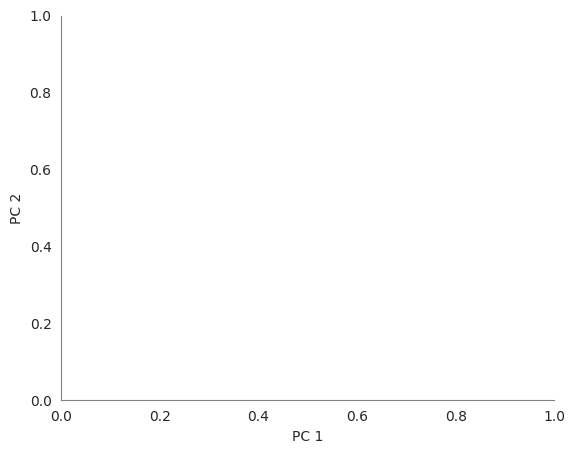

In [10]:
# min_dist=0.2
# spread= 5
# n_epochs=None
# metric='cosine'
for filename in filenames:
    dataNpy, dataL = readData(filename)
    _ = makePCA(dataNpy, dataL, hue_name='Metadata_Cmpd', name=filename)
    # # _ = makeUMAP(dataNpy, dataL, name=filename)
    # _ = makeUMAP(dataNpy, dataL, hue_name='Metadata_Radius', name=filename, nn=150)
    # _ = makeUMAP(dataNpy, dataL, hue_name='Metadata_Radius', name=filename, is_supervised=False)


In [15]:
for filename in filenames:
    dataNpy, dataL = readData(filename)
    # _ = makePCA(dataNpy, dataL, hue_name='Metadata_Well', name=filename)
    # # _ = makeUMAP(dataNpy, dataL, name=filename)
    _ = makeUMAP(dataNpy, dataL, hue_name='Metadata_Cmpd', name=filename, nn=150)
    # _ = makeUMAP(dataNpy, dataL, hue_name='Metadata_Well', name=filename, is_supervised=False)

KeyboardInterrupt: 

In [ ]:


for statmet in statmets:
    for filename in filenames:
        dataNpy, dataL = readData(filename, statmet=statmet)
        _ = makePCA(dataNpy, dataL, hue_name='Metadata_Radius', name=filename, statmet=statmet)
        # _ = makeUMAP(dataNpy, dataL, name=filename, statmet=statmet)
        _ = makeUMAP(dataNpy, dataL, hue_name='Metadata_Radius', name=filename, statmet=statmet, nn=150)
        # _ = makeUMAP(dataNpy, dataL, name=filename, statmet=statmet, is_supervised=False)
        _ = makeUMAP(dataNpy, dataL, hue_name='Metadata_Radius', name=filename, statmet=statmet, nn=150, is_supervised=False)